In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function Definitions

def sine_gaussian_waveform(t, A, t0, tau, f0, phi0):
    gaussian_envelope = A * np.exp(-((t - t0)**2) / (2 * tau**2))
    sine_wave = np.cos(2 * np.pi * f0 * t + phi0)
    return gaussian_envelope * sine_wave

def add_glitches(signal, glitch_frequency, glitch_amplitude, glitch_duration, num_points):
    signal_with_glitches = signal.copy()
    for _ in range(int(glitch_frequency * num_points)):
        start_idx = np.random.randint(0, num_points - glitch_duration)
        end_idx = start_idx + glitch_duration
        glitch = np.random.uniform(-glitch_amplitude, glitch_amplitude, glitch_duration)
        signal_with_glitches[start_idx:end_idx] += glitch
    return signal_with_glitches

def add_noise(signal, noise_level_base, noise_variation, num_points):
    noise_level = abs(noise_level_base + np.random.uniform(-noise_variation, noise_variation))
    noise = np.random.uniform(-noise_level, noise_level, num_points)
    return signal + noise

def generate_waveform_data(num_samples, num_points, A_base, A_variation, t0_base, t0_variation, tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, time_length_base, time_length_variation, glitch_frequency=0.0, glitch_amplitude=0.0, glitch_duration=0, signal_present=True):
    data = [] 
    labels = []
    
    for _ in range(num_samples):
        A = A_base + np.random.uniform(-A_variation, A_variation)
        t0 = t0_base + np.random.uniform(-t0_variation, t0_variation)
        f0 = f0_base + np.random.uniform(-f0_variation, f0_variation)
        noise_level = abs(noise_level_base + np.random.uniform(-noise_variation, noise_variation))
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        
        t = np.linspace(0, time_length, num_points)

        if signal_present:
            waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
            signal_with_noise = add_noise(waveform, noise_level_base, noise_variation, num_points)
            label = np.zeros_like(t)
            signal_start = np.argmin(np.abs(t - t0 + 3 * tau))
            signal_end = np.argmin(np.abs(t - t0 - 3 * tau))
            label[signal_start:signal_end] = 1
        else:
            signal_with_noise = np.random.uniform(-noise_level, noise_level, t.shape)
            label = np.zeros_like(t)

        if glitch_frequency > 0:
            signal_with_noise = add_glitches(signal_with_noise, glitch_frequency, glitch_amplitude, glitch_duration, num_points)
        
        sampled_amplitudes = signal_with_noise
        features = sampled_amplitudes
        data.append(features)
        labels.append(label)
    
    return np.array(data), np.array(labels)

def generate_coincidence_test_data(test_data, test_labels, noise_level_base, noise_variation, noise_level_coincidence, noise_variation_coincidence, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, signal_probability=0.5):
    coincident_data = []
    coincident_labels = []
    
    for i in range(test_data.shape[0]):
        if np.random.rand() < signal_probability:
            # Generate data with a signal
            signal = test_data[i]
            label = test_labels[i]
            signal_with_noise = add_noise(signal, noise_level_coincidence, noise_variation_coincidence, len(signal))
            
            # Add glitches
            if glitch_frequency_coincidence > 0:
                signal_with_noise = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence * np.random.uniform(-1, 1), glitch_duration_coincidence, len(signal))
            
            coincident_data.append(signal_with_noise)
            coincident_labels.append(label)
        else:
            # Generate pure noise with glitches
            signal_with_noise = np.random.uniform(-noise_level_coincidence, noise_level_coincidence, len(test_data[i]))
            if glitch_frequency_coincidence > 0:
                signal_with_noise = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence * np.random.uniform(-1, 1), glitch_duration_coincidence, len(signal_with_noise))
            label = np.zeros_like(signal_with_noise)
            
            coincident_data.append(signal_with_noise)
            coincident_labels.append(label)
    
    return np.array(coincident_data), np.array(coincident_labels)

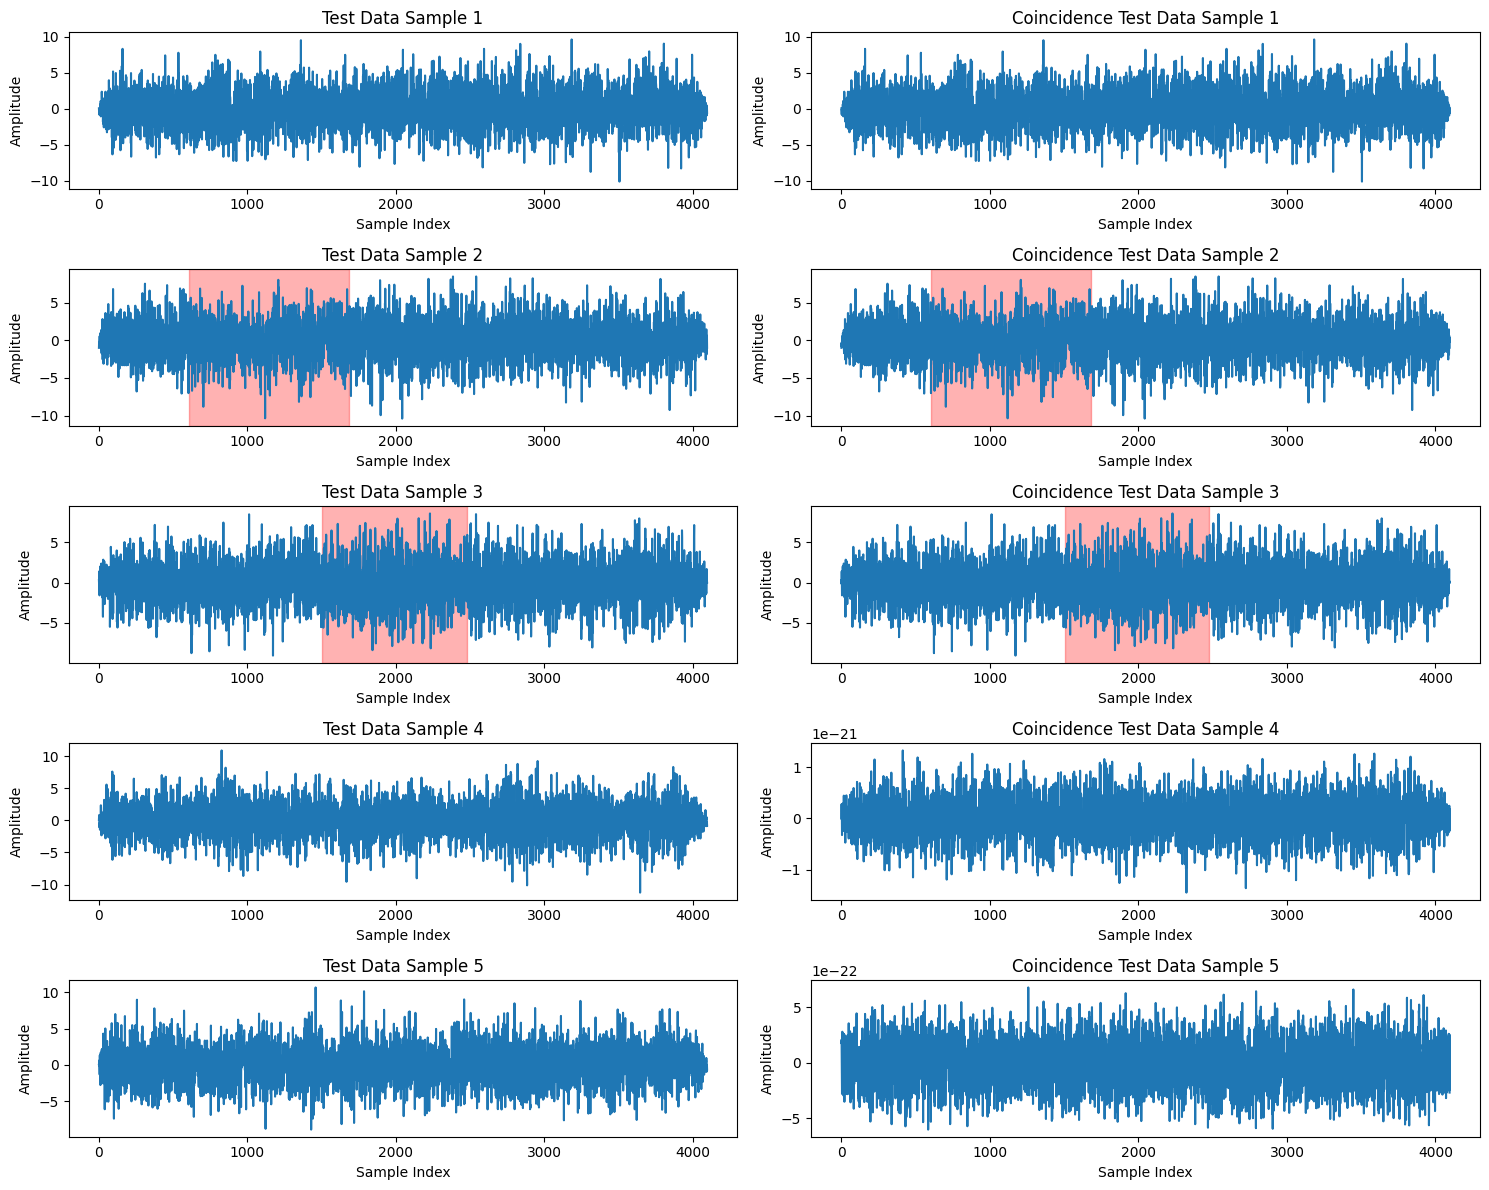

In [52]:
# Parameters for waveform generation
num_samples_per_class = 500
num_points = 4096

A_base = 3e-22
A_variation = 0e-22
t0_base = 0.5
t0_variation = 0.3
tau = 0.05
f0_base = 100
f0_variation = 10
phi0 = 0.0
noise_level_base = 3e-22
noise_variation = 0
time_length_base = 1.0
time_length_variation = 0.3

glitch_frequency = 0.2
glitch_amplitude = 3e-22
glitch_duration = 100

# Generate data with and without signal
data_with_signal, labels_with_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=True
)

data_without_signal, labels_without_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=False
)


# Combine and shuffle data and labels
data = np.concatenate([data_with_signal, data_without_signal])
labels = np.concatenate([labels_with_signal, labels_without_signal])

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

data=data/A_base
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=42)

# Generate coincident test data with 50% signal probability and distinct glitches and noise
glitch_frequency_coincidence = 0.3
glitch_amplitude_coincidence = 2e-22
glitch_duration_coincidence = 200
noise_level_coincidence = 3e-22
noise_variation_coincidence = 0
signal_probability = 0.5  # 50% chance of having a signal

coincidence_test_data, coincidence_test_labels = generate_coincidence_test_data(
    X_test, y_test, noise_level_base, noise_variation, noise_level_coincidence, noise_variation_coincidence, 
    glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence,
    signal_probability=signal_probability
)

# Save data and labels to CSV files
def save_to_csv(data, labels, prefix):
    df_data = pd.DataFrame(data.T)
    df_labels = pd.DataFrame(labels.T)
    df_data.to_csv(f'{prefix}_data.csv', index=False)
    df_labels.to_csv(f'{prefix}_labels.csv', index=False)

save_to_csv(X_train, y_train, 'train')
save_to_csv(X_test, y_test, 'test')
save_to_csv(coincidence_test_data, coincidence_test_labels, 'coincidence_test')

# Plotting function for side-by-side comparison
def plot_samples_side_by_side(samples1, labels1, samples2, labels2, title_prefix1, title_prefix2, num_samples=5):
    plt.figure(figsize=(15, 12))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.plot(samples1[i] )
        plt.title(f'{title_prefix1} Sample {i+1}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        if np.any(labels1[i] == 1):
            signal_region = np.where(labels1[i] == 1)[0]
            if len(signal_region) > 0:
                start_idx = signal_region[0]
                end_idx = signal_region[-1]
                plt.axvspan(start_idx, end_idx, color='red', alpha=0.3)
        
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.plot(samples2[i])
        plt.title(f'{title_prefix2} Sample {i+1}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        if np.any(labels2[i] == 1):
            signal_region = np.where(labels2[i] == 1)[0]
            if len(signal_region) > 0:
                start_idx = signal_region[0]
                end_idx = signal_region[-1]
                plt.axvspan(start_idx, end_idx, color='red', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot some samples
plot_samples_side_by_side(X_test, y_test, coincidence_test_data, coincidence_test_labels, 'Test Data', 'Coincidence Test Data')